In [250]:
# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

#updated yet?

In [251]:
# Import pandas, numpy and seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql

from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns',None)


In [252]:
# Define the path to the SQLite database file

#Roberto file path to DB
#db_path = 'C:/Users/rober/SQLite/CyberSentryDB.db'

#Andres file path to DB
db_path = 'C:/Users/andre/SQLite/CyberSentryDB.db'

# Establish a connection to the database specified by db_path
conn = sql.connect(db_path)

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Execute a SQL query to select all records from the 'network_activity' table
# and store the result in a pandas DataFrame 'df' for further analysis
#df = pd.read_sql_query("SELECT * FROM network_activity", conn)
df_test = pd.read_sql_query("SELECT * FROM testing_data", conn)
df_train = pd.read_sql_query("SELECT * FROM training_data", conn)

# Close the cursor to release database resources
cursor.close()

# Close the connection to the database to ensure data integrity and release resources
conn.close()


In [253]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

# Assign name for columns
df_train.columns = columns
df_test.columns = columns

In [282]:
# Concatenate dataframes
df_all = pd.concat([df_train, df_test], ignore_index=True)

# Optionally, if you want to drop the old index and not add it as a column
df_all = df_all.reset_index(drop=True)

In [255]:
# For the training dataset:
# Keep rows with 'outcome' as 'normal' unchanged.
df_train.loc[df_train['outcome'] == "normal", "outcome"] = 'normal'  
# Change 'outcome' values not equal to 'normal' to 'attack' in the training dataset.
df_train.loc[df_train['outcome'] != 'normal', "outcome"] = 'attack'

df_test.loc[df_test['outcome'] == "normal", "outcome"] = 'normal'  
# Change 'outcome' values not equal to 'normal' to 'attack' in the training dataset.
df_test.loc[df_test['outcome'] != 'normal', "outcome"] = 'attack'

In [256]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,attack,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [257]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,attack,21
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,attack,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,attack,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,attack,11


In [258]:
df_all.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [283]:
def bar_plot(df, cols_list, rows, cols):
    # Create a grid of subplots with the specified number of rows and columns.
    fig, axes = plt.subplots(rows, cols, figsize=(20, 7))
    fig.tight_layout(pad=1.0)  # Add spacing between plots for clarity

    # Flatten the axes array and iterate over it along with the column names in cols_list.
    for ax, col in zip(axes.ravel(), cols_list):
        # Use Seaborn's countplot to create a bar chart.
        sns.countplot(x=col, data=df, ax=ax)

        # Calculate the total number of data points for the percentage calculation.
        total = len(df[col])

        # Iterate through the patches (bars) in the barplot to get their properties.
        for p in ax.patches:
            # Calculate the percentage and format it.
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            # Get the x and y coordinates to place the text.
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            # Place the text on the bar.
            ax.text(x, y, percentage, ha='center', va='bottom')

        # Set the title of the current subplot to the name of the column.
        ax.set_title(str(col), fontsize=12)

        # Rotate the x-axis labels for better readability.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Adjust the layout and display the figure with all the bar charts.
    plt.tight_layout()
    plt.show()


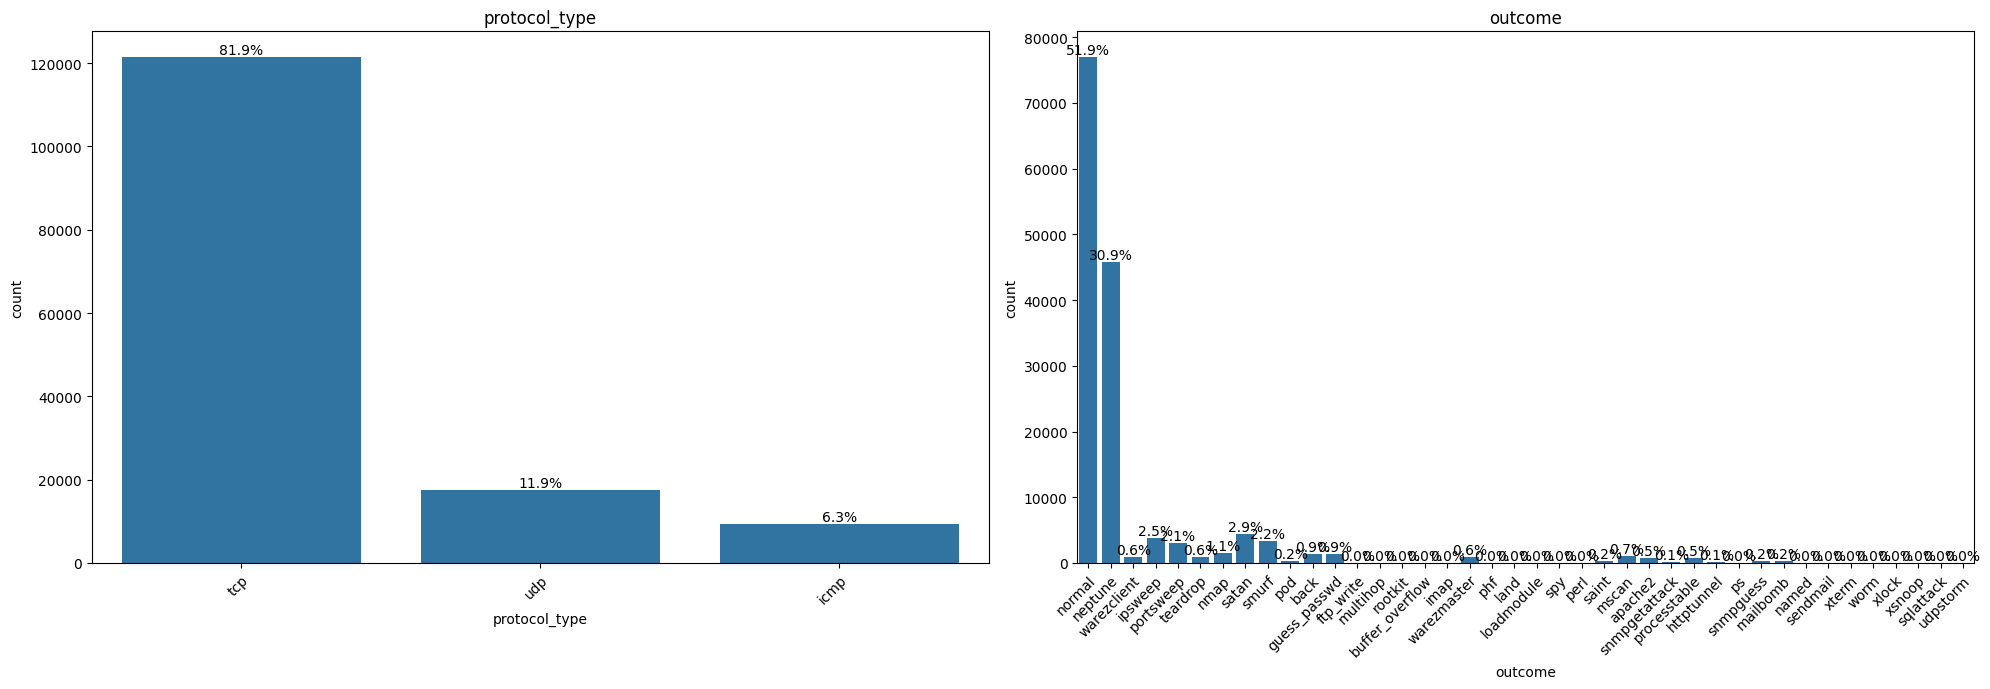

In [261]:
bar_plot(df_all, ['protocol_type', 'outcome'],1,2)

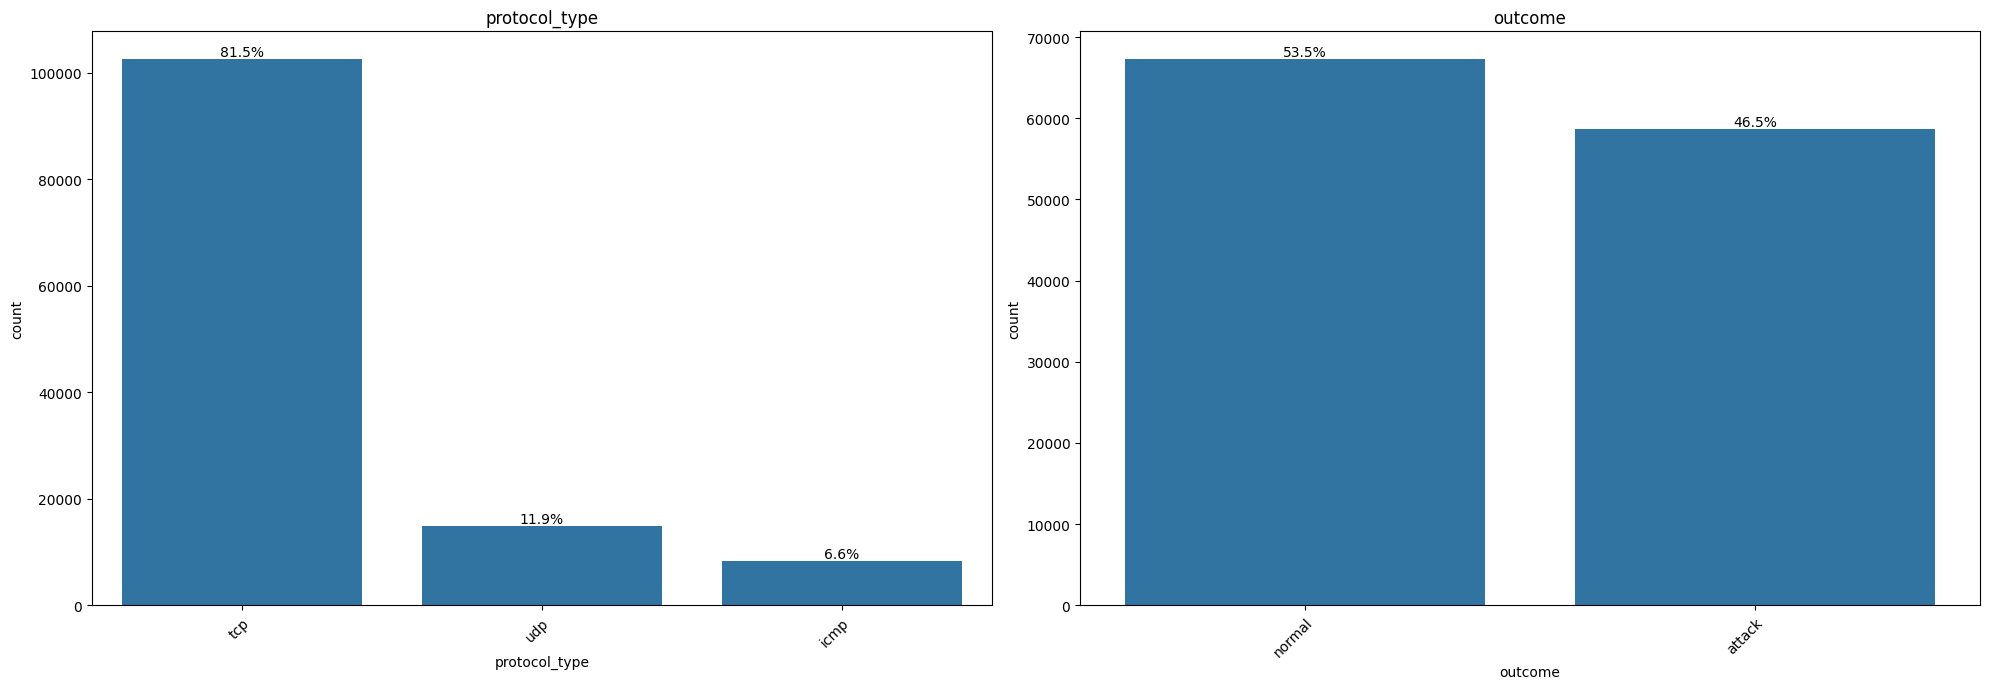

In [262]:
bar_plot(df_train, ['protocol_type', 'outcome'],1,2)

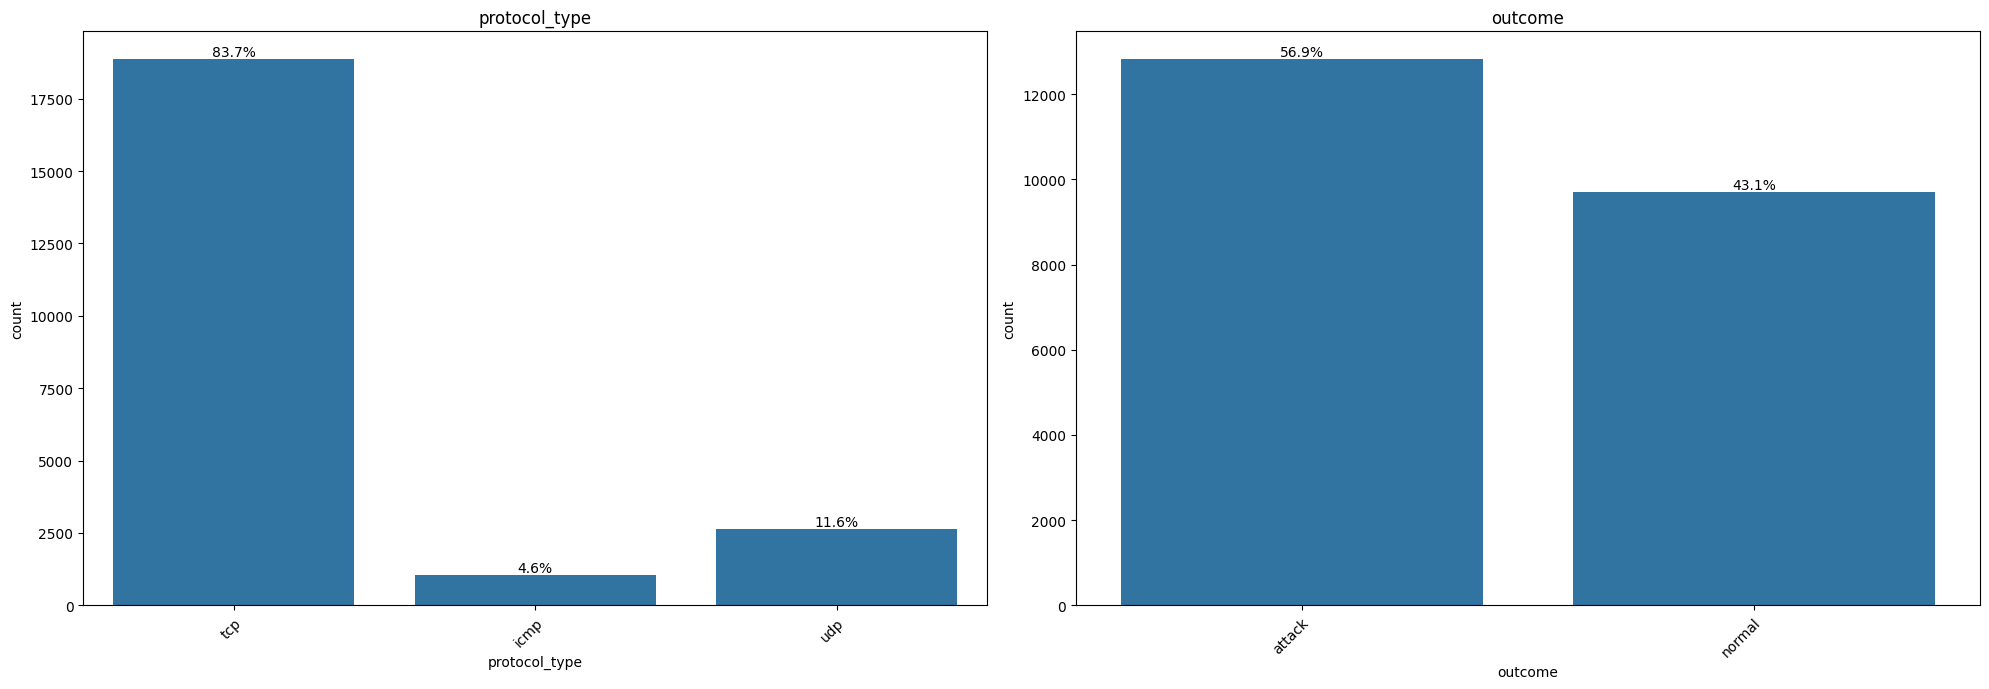

In [263]:
bar_plot(df_test, ['protocol_type', 'outcome'],1,2)

In [264]:
def pie_plot(df, cols_list, rows, cols):
    # Create a grid of subplots with the specified number of rows and columns.
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    fig.tight_layout(pad=1.0)  # Add spacing between plots for clarity

    # If there is only one row or one column, axes is a 1D numpy array.
    if rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.ravel()  # Flatten the axes array for iteration

    # Iterate over the axes array and the column names in cols_list.
    for ax, col in zip(axes, cols_list):
        # Calculate the value counts for the current column.
        counts = df[col].value_counts()

        # Create a pie chart in each subplot.
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)

        # Set the title of the current subplot to the name of the column.
        ax.set_title(str(col), fontsize=12)

    # Adjust the layout and display the figure with all the pie charts.
    plt.tight_layout()
    plt.show()

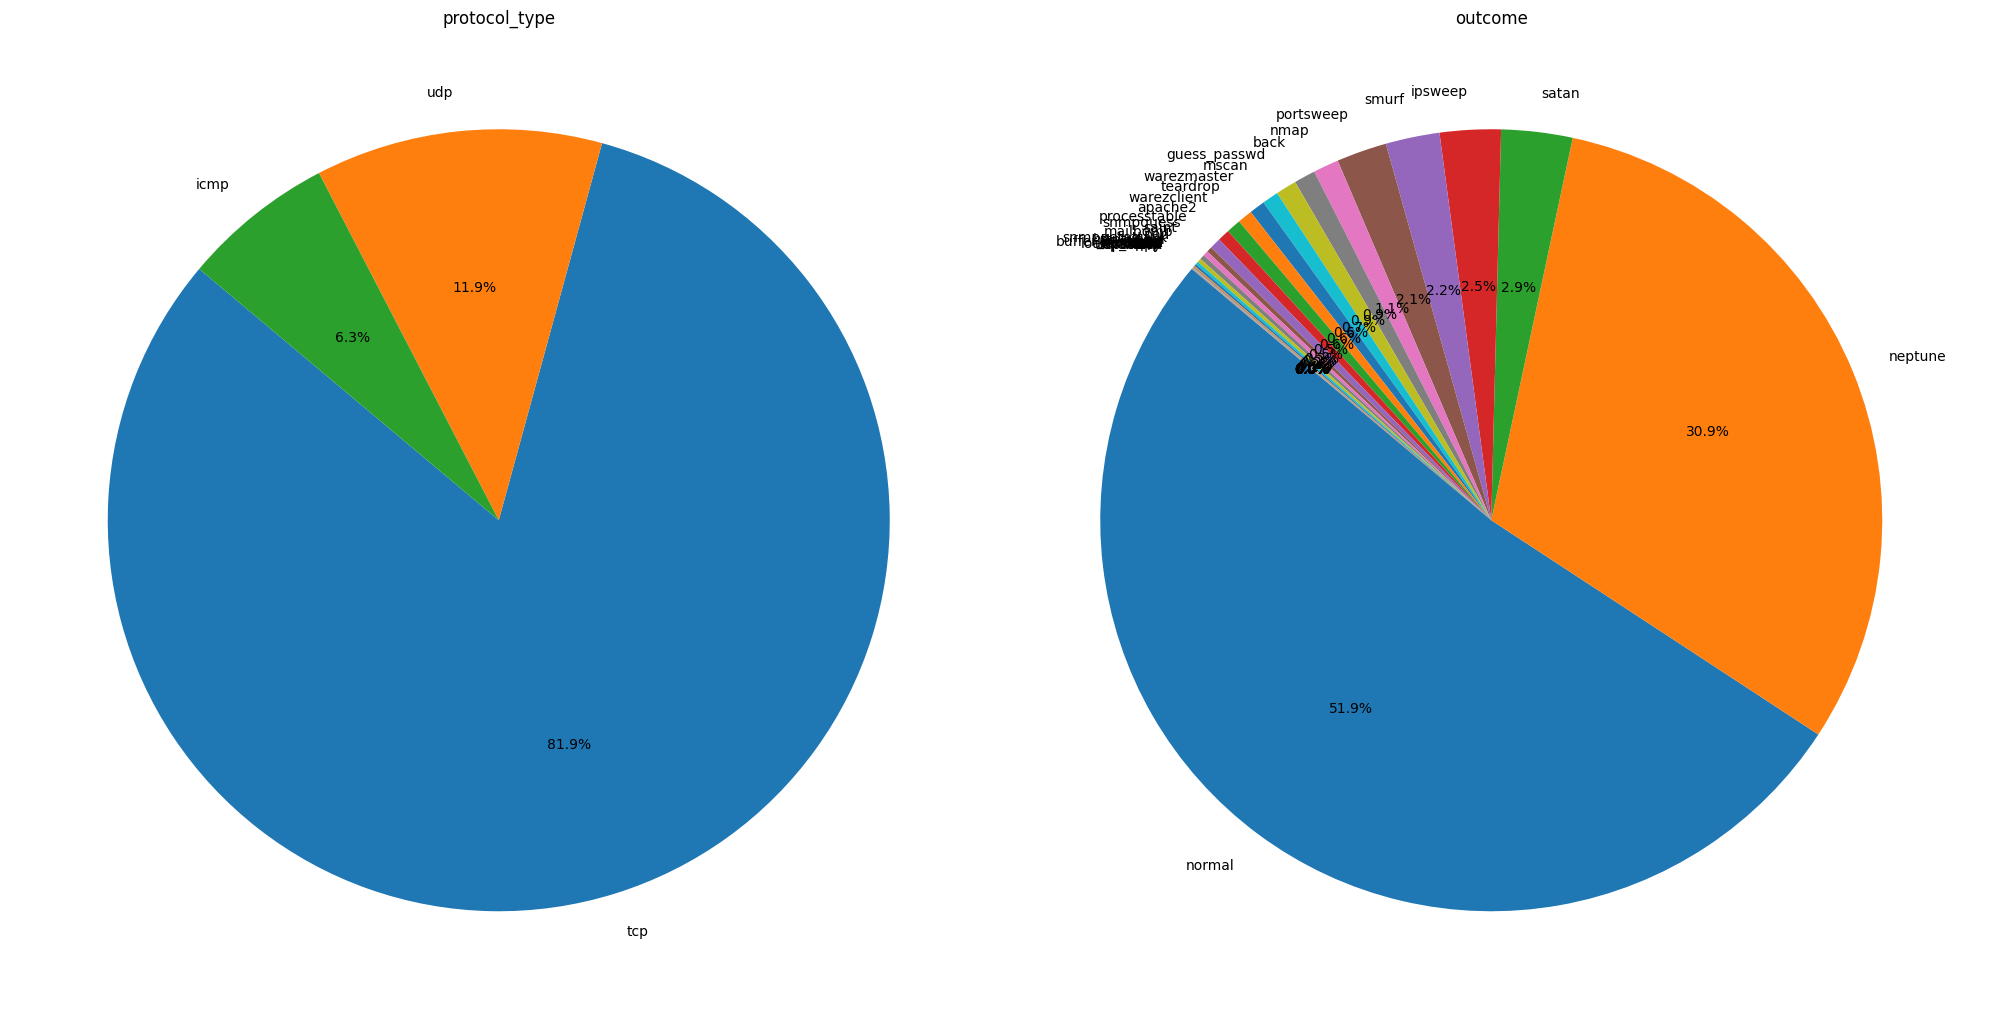

In [265]:
pie_plot(df_all, ['protocol_type','outcome'], 1, 2)

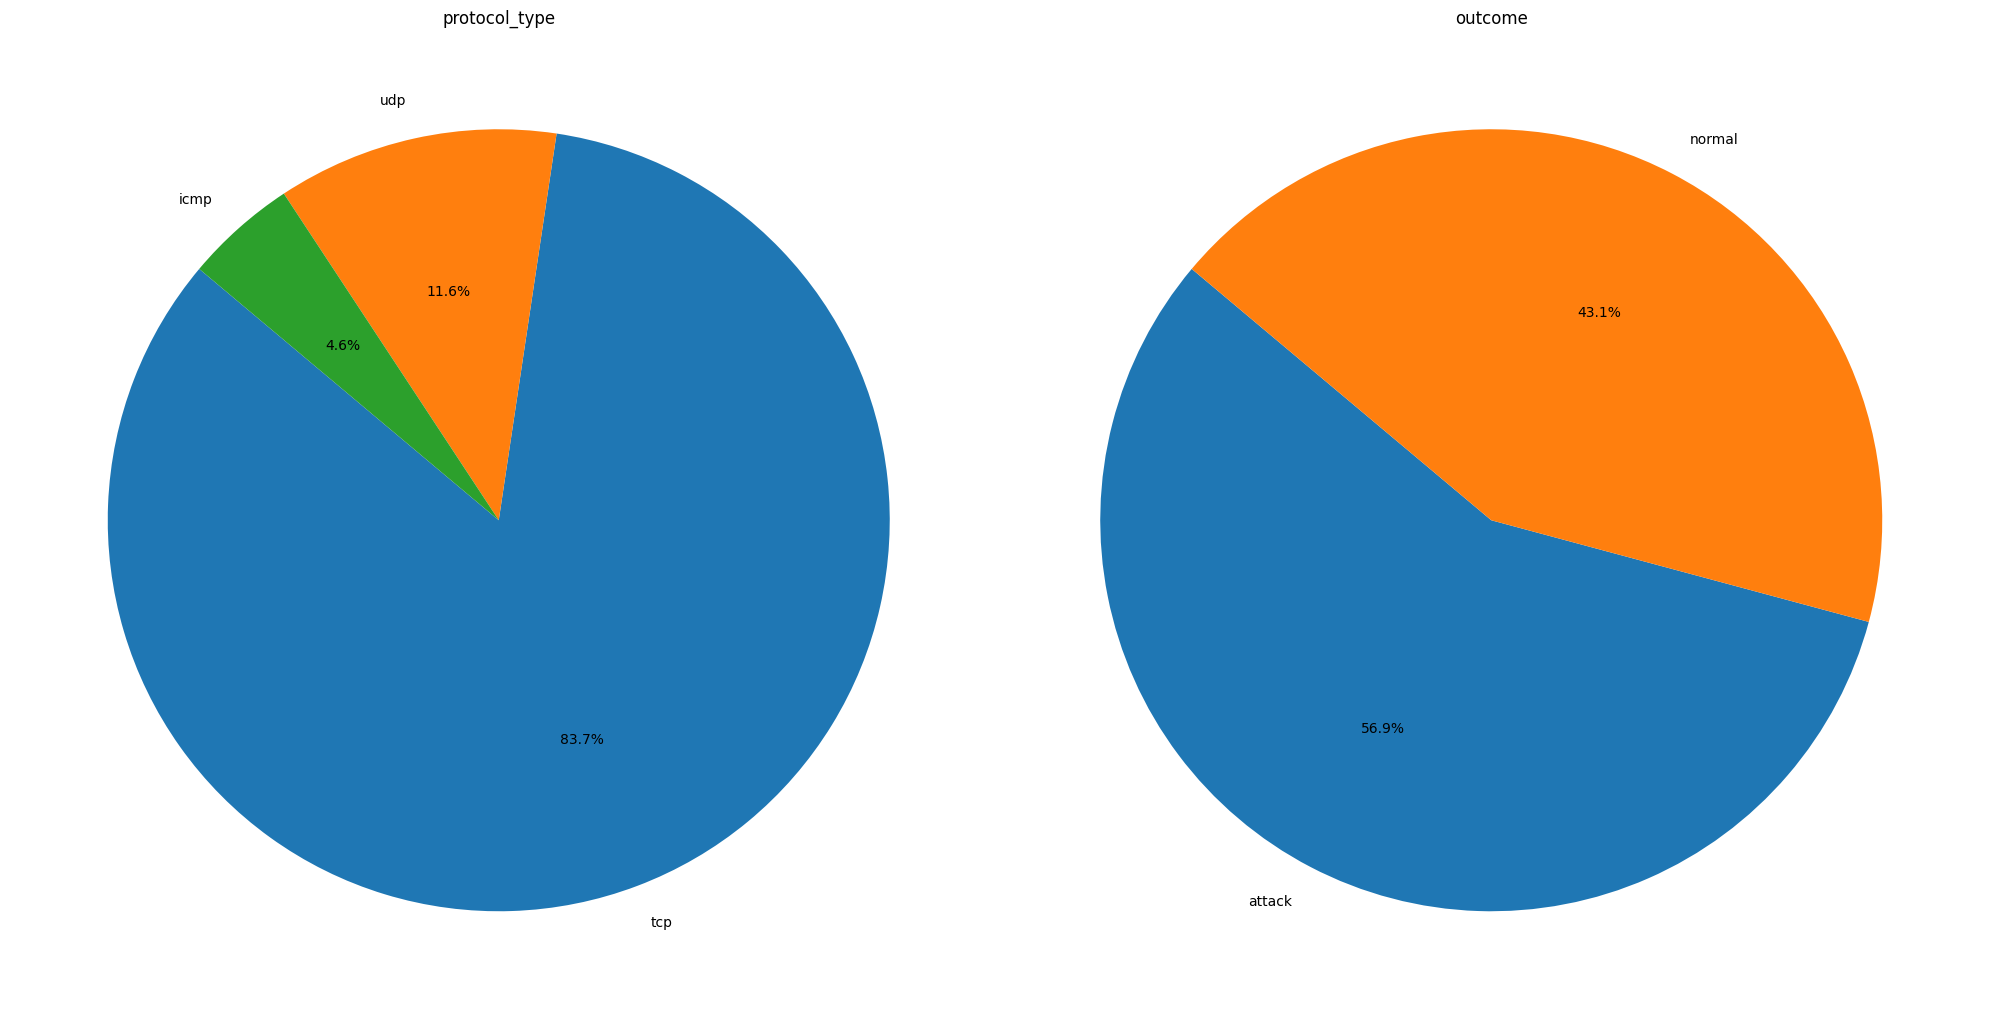

In [266]:
pie_plot(df_test, ['protocol_type','outcome'], 1, 2)

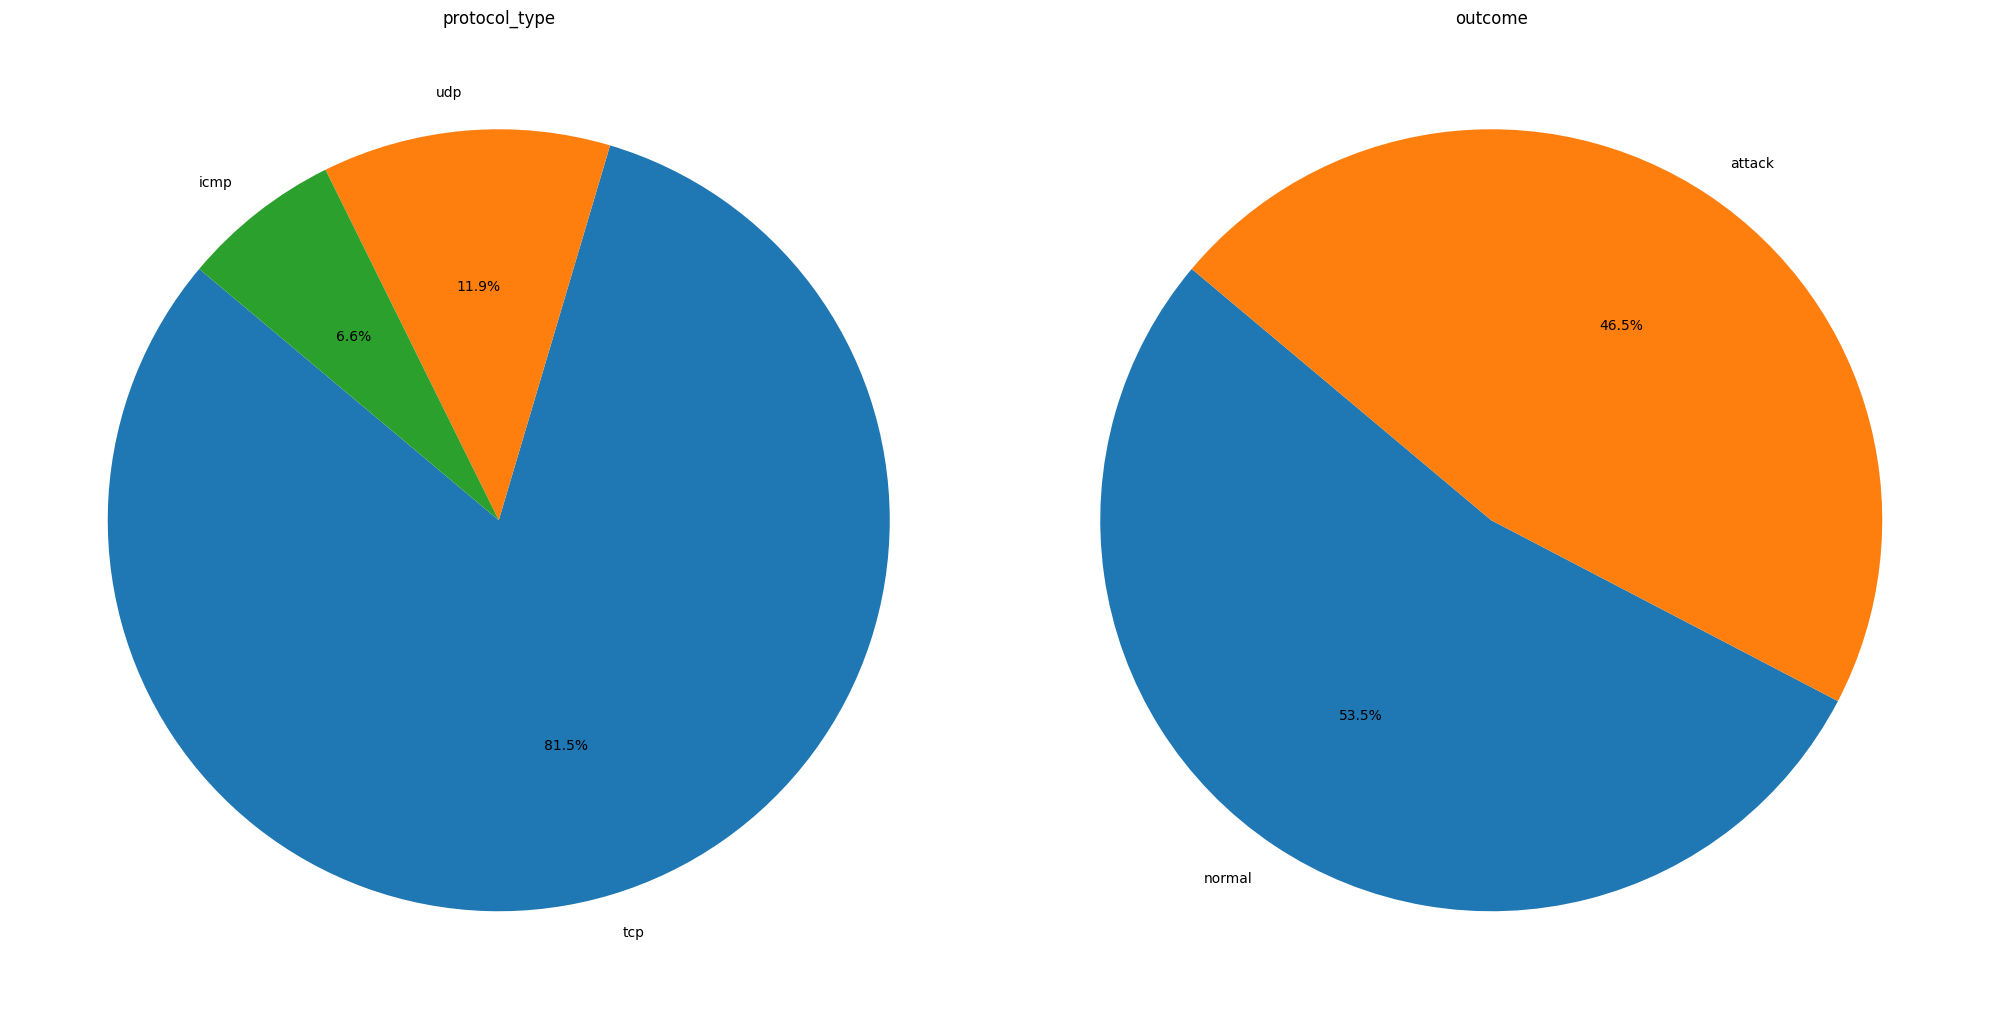

In [267]:
pie_plot(df_train, ['protocol_type','outcome'], 1, 2)

------------------------------

# **4. Preprocessing the Data**

## 4.1. Scaling the Data

In [268]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,attack,21
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,attack,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,attack,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,attack,11


In [273]:
def preprocess(dataframe, scaler=None):
    # Define categorical and numerical columns
    cat_cols = ['is_host_login', 'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_guest_login', 'level', 'outcome']
    num_cols = dataframe.drop(columns=cat_cols).columns

    # Scale numerical columns if scaler is not provided
    if not scaler:
        scaler = StandardScaler()  # Initialize StandardScaler if not provided
    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])  # Fit and transform numerical columns using scaler

    # Encode 'outcome' as binary (0 for 'normal', 1 for other values)
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    # Encode categorical columns as dummy variables
    dataframe = pd.get_dummies(dataframe, columns=['protocol_type', 'service', 'flag'])

    return dataframe, scaler  # Return preprocessed DataFrame and scaler

In [274]:
# Fit and transform the training data
df_train_scaled, scalar = preprocess(df_train)
df_test_scaled, scalar = preprocess(df_test)

In [306]:
# Get the columns that are not common between the two
train_cols = set(df_train_scaled.columns)
test_cols = set(df_test_scaled.columns)

# Add missing columns to df_test
for col in train_cols - test_cols:
    df_test_scaled[col] = False

# Add missing columns to df_train
for col in test_cols - train_cols:
    df_train_scaled[col] = False

# Ensure the order of columns is the same
df_test_scaled = df_test_scaled[df_train_scaled.columns]

In [307]:
df_train_scaled.shape

(125973, 124)

In [308]:
df_test_scaled.shape

(22544, 124)

In [309]:
def find_diff_col(df1, df2):
    # Find the difference in columns
    diff_1_to_2 = set(df1.columns) - set(df2.columns)
    diff_2_to_1 = set(df2.columns) - set(df1.columns)

    # Print out the different column names
    print("Columns in df1 not in df2:", diff_1_to_2)
    print("Columns in df2 not in df1:", diff_2_to_1)

In [310]:
find_diff_col(df_train_scaled, df_test_scaled)

Columns in df1 not in df2: set()
Columns in df2 not in df1: set()


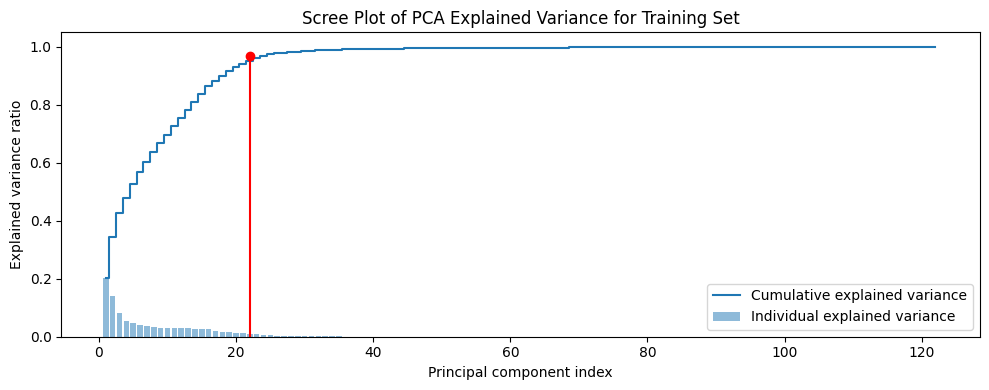

In [292]:
# For the training set
# Prepare feature variables for training set
X_train = df_train_scaled.drop(['outcome', 'level'], axis=1)

# Apply PCA to assess dimensionality reduction for the training set
pca_train = PCA()
pca_train.fit(X_train)

# Generate a scree plot for the training set to visualize explained variance ratio by each component
plt.figure(figsize=(10, 4))
explained_variance_ratio_train = pca_train.explained_variance_ratio_
cumulative_explained_variance_train = np.cumsum(explained_variance_ratio_train)
plt.bar(range(1, len(explained_variance_ratio_train) + 1), explained_variance_ratio_train, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance_train) + 1), cumulative_explained_variance_train, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Scree Plot of PCA Explained Variance for Training Set')
plt.legend(loc='best')
plt.stem(22, 0.97, linefmt = 'red', label= 'Elbow')
plt.tight_layout()  # Adjust layout to fit everything
plt.show()


In [345]:
# Prepare feature variables from the scaled datasets, excluding 'outcome' and 'level' from features
X_train = df_train_scaled.drop(['outcome', 'level'], axis=1)
Y_train = df_train_scaled['outcome'].values.astype('int')

x_test = df_test_scaled.drop(['outcome', 'level'], axis=1)  # Use consistent naming convention
y_test = df_test_scaled['outcome'].values.astype('int')

# Instantiate PCA with desired number of components
pca = PCA(n_components=20)  # Example: reducing to 22 components

# Fit PCA on the training data and transform it
X_train_reduced = pca.fit_transform(X_train)

# Transform the test data using the already fitted PCA (do not fit it again)
x_test_reduced = pca.transform(x_test)  # Use transform, not fit_transform

# Correctly print the number of features after PCA
print(f"Number of original features in X_train is {X_train.shape[1]} and number of reduced features after PCA is {X_train_reduced.shape[1]}")
print(f"Number of original features in X_test is {x_test.shape[1]} and number of reduced features after PCA is {x_test_reduced.shape[1]}")


Number of original features in X_train is 122 and number of reduced features after PCA is 20
Number of original features in X_test is 122 and number of reduced features after PCA is 20


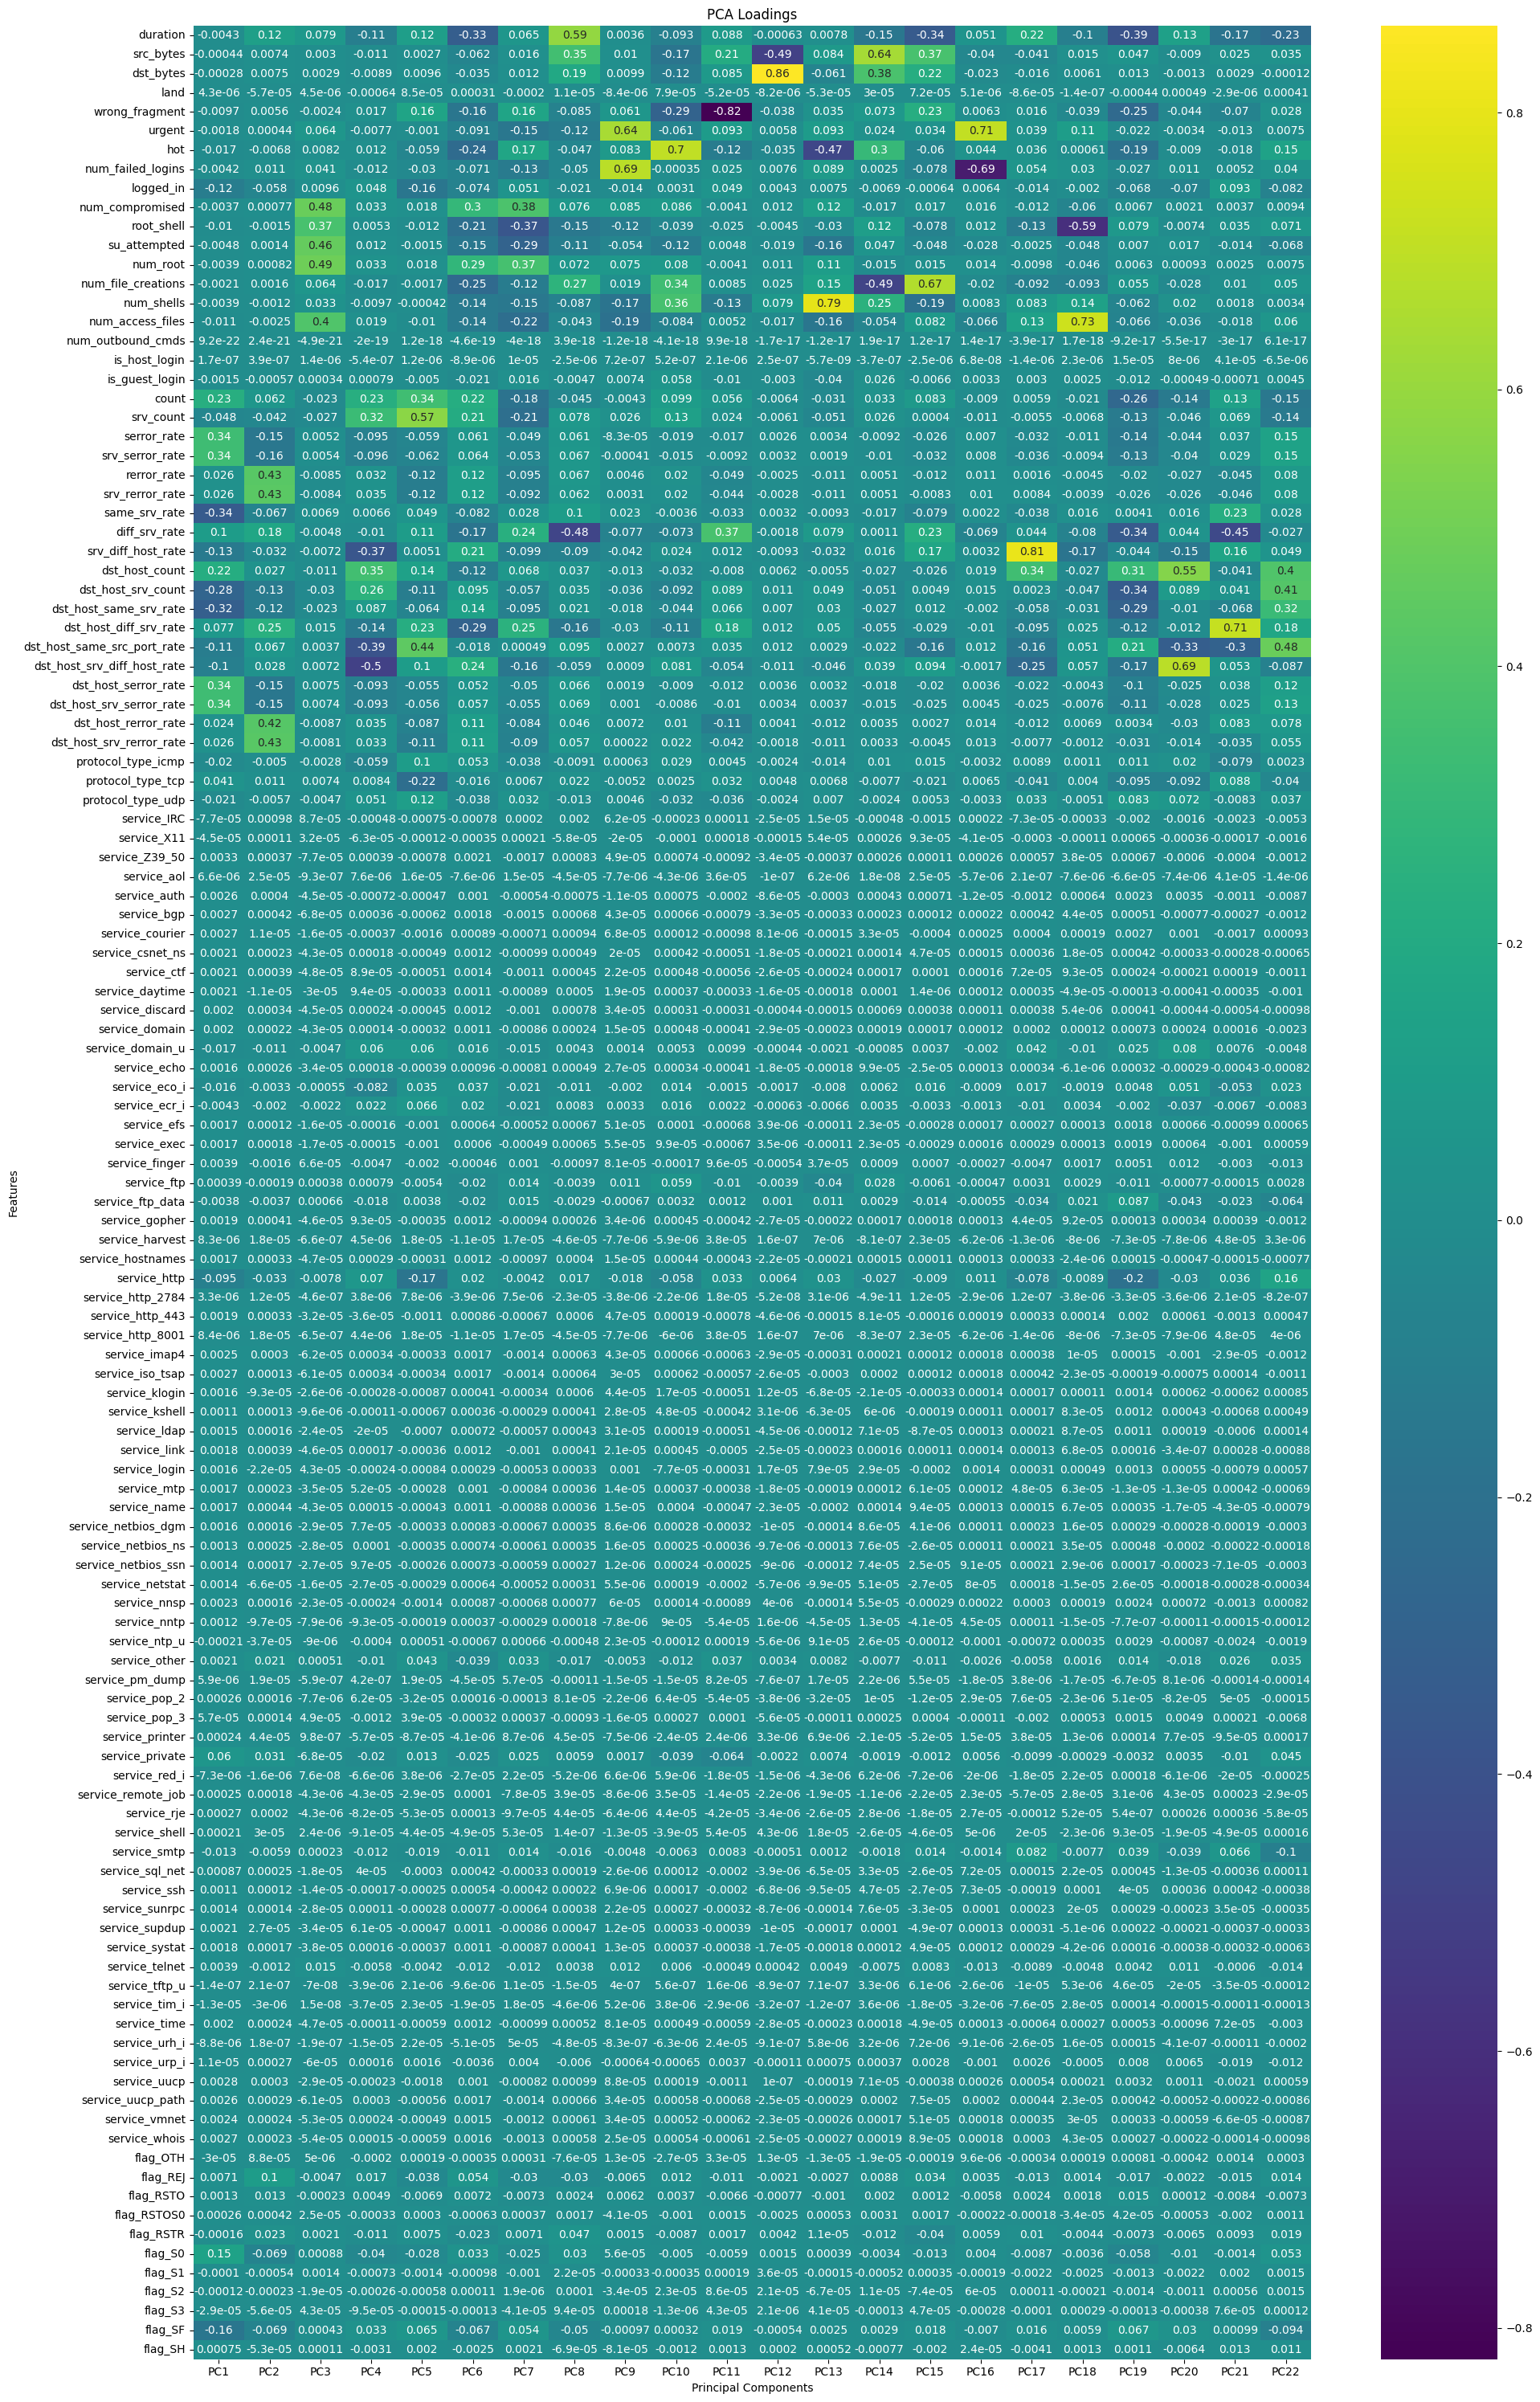

In [330]:
# Get the PCA components (loadings)
loadings = pca.components_

# Create a DataFrame of loadings
features = X_train.columns
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=features)

# Plot the feature contributions to the components
plt.figure(figsize=(20, 30))
sns.heatmap(loadings_df, cmap='viridis', annot=True)
plt.title('PCA Loadings')
plt.ylabel('Features')
plt.xlabel('Principal Components')
plt.tight_layout()
plt.show()

In [346]:
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):

    # Fit the model using the training data
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_precision = precision_score(y_train, y_pred_train, average='macro')
    test_precision = precision_score(y_test, y_pred_test, average='macro')
    train_recall = recall_score(y_train, y_pred_train, average='macro')
    test_recall = recall_score(y_test, y_pred_test, average='macro')

    # Output metrics
    print(f"Training Accuracy {name}: {train_accuracy*100:.2f}%")
    print(f"Test Accuracy {name}: {test_accuracy*100:.2f}%")
    print(f"Training Precision {name}: {train_precision*100:.2f}%")
    print(f"Test Precision {name}: {test_precision*100:.2f}%")
    print(f"Training Recall {name}: {train_recall*100:.2f}%")
    print(f"Test Recall {name}: {test_recall*100:.2f}%")

    # Display confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred_test)
    display_labels = ['Normal', 'Attack']
    cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=display_labels)
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display.plot(ax=ax)
    plt.grid(False)
    plt.show()

# You will call the evaluate_classification function like this, for example:
# evaluate_classification(your_model, 'Your Model Name', X_train, X_test, y_train_class, y_test_class)


Training Accuracy Logistic Regression: 94.77%
Test Accuracy Logistic Regression: 77.07%
Training Precision Logistic Regression: 94.81%
Test Precision Logistic Regression: 79.10%
Training Recall Logistic Regression: 94.67%
Test Recall Logistic Regression: 78.80%


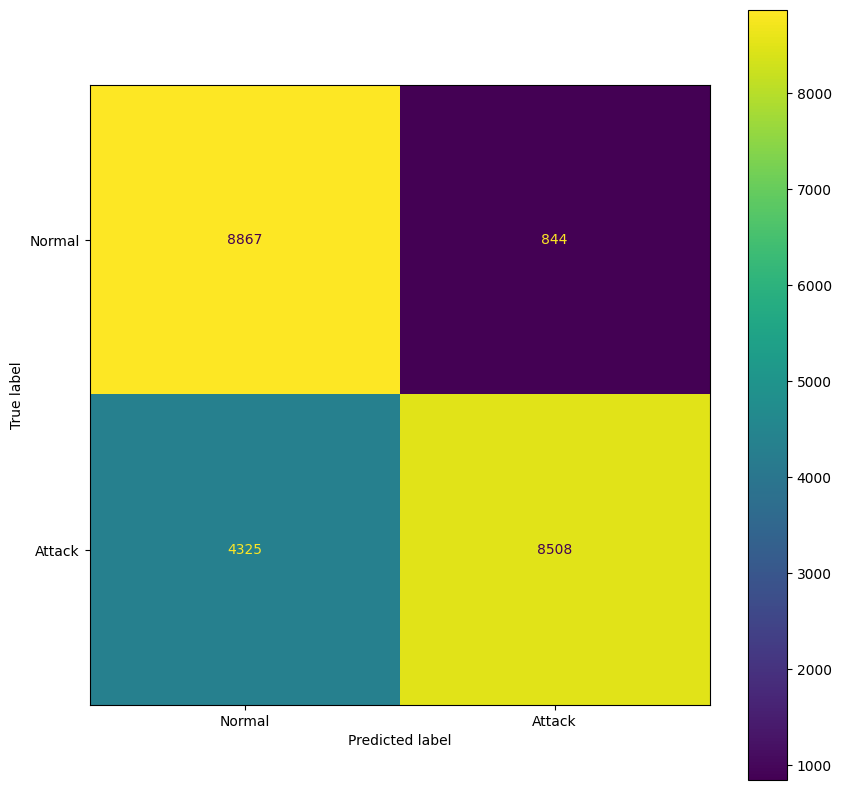

Cross-Validation Accuracy Scores: [0.9453463  0.94697361 0.94919627 0.94760657 0.9479638 ]
Mean CV Accuracy: 0.95, Standard Deviation in CV Accuracy: 0.00


In [347]:
# Initialize Logistic Regression model with various parameters
lr = LogisticRegression(
    penalty='l2',                # Specifies the norm used in the penalization (regularization). 'l2' is the standard L2 regularization.
    tol=1e-4,                    # Tolerance for stopping criteria. This tells the model when to stop searching for a minimum (convergence).
    C=0.001,                       # Inverse regularization strength. Smaller values specify stronger regularization.
    fit_intercept=True,          # Specifies if a constant (bias or intercept) should be added to the decision function.
    class_weight=None,           # Weights associated with classes. If None, all classes are supposed to have weight one.
    random_state=42,           # The seed used by the random number generator (for shuffling the data).
    solver='newton-cg',                # Algorithm to use in the optimization problem. For small datasets, 'liblinear' is a good choice, whereas 'sag' and 'saga' are faster for large ones.
    max_iter=100000,              # Maximum number of iterations for the solvers to converge.
    n_jobs=8,                 # Number of CPU cores used when parallelizing. None means 1 unless in a joblib.parallel_backend context.
    l1_ratio=None                # The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.
)

# Evaluate the fitted model's performance on both the training and testing datasets
# The 'evaluate_classification' function prints out several metrics and displays a confusion matrix
evaluate_classification(lr, "Logistic Regression", X_train_reduced, x_test_reduced, Y_train, y_test)

# Perform 5-fold cross-validation to assess model's stability and performance across different subsets of the data
# Cross-validation is crucial for verifying the model's ability to generalize to unseen data
cv_scores = cross_val_score(lr, X_train_reduced, Y_train, cv=5, scoring='accuracy')

# Print the accuracy scores obtained from cross-validation
# These scores provide insight into how the model performs on different folds of the training data
print("Cross-Validation Accuracy Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores to get an overall performance metric and its variability
mean_cv_accuracy = cv_scores.mean()
std_cv_accuracy = cv_scores.std()
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}, Standard Deviation in CV Accuracy: {std_cv_accuracy:.2f}")


Training Accuracy RandomForestClassifier: 99.56%
Test Accuracy RandomForestClassifier: 73.24%
Training Precision RandomForestClassifier: 99.57%
Test Precision RandomForestClassifier: 77.53%
Training Recall RandomForestClassifier: 99.53%
Test Recall RandomForestClassifier: 75.73%


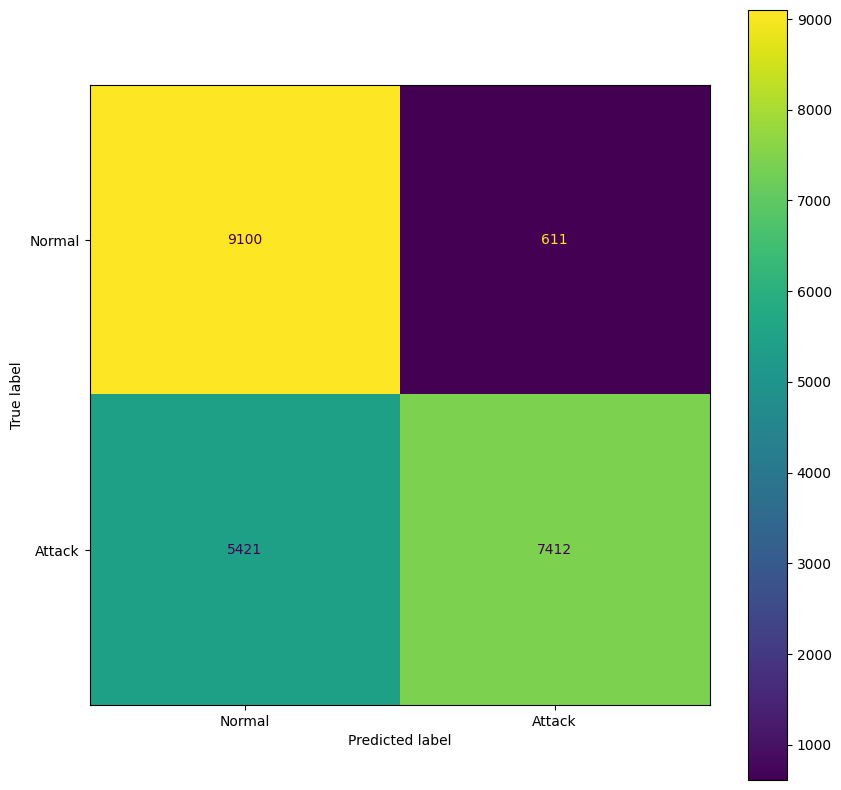

In [362]:
# Initialize the RandomForestClassifier with various parameters
rf = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest.
    criterion='gini',        # The function to measure the quality of a split. 'gini' for Gini impurity and 'entropy' for information gain.
    max_depth=10,          # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    min_samples_split=20,     # The minimum number of samples required to split an internal node.
    min_samples_leaf=1,      # The minimum number of samples required to be at a leaf node.
    min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
    max_leaf_nodes=None,     # Grow trees with `max_leaf_nodes` in best-first fashion. Best nodes are defined as relative reduction in impurity.
    min_impurity_decrease=0.0, # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    bootstrap=True,          # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
    oob_score=False,         # Whether to use out-of-bag samples to estimate the generalization accuracy.
    n_jobs=-1,             # The number of jobs to run in parallel. None means 1. -1 means using all processors.
    random_state=None,       # Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node.
    verbose=0,               # Controls the verbosity when fitting and predicting.
    warm_start=False,        # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
    class_weight=None,       # Weights associated with classes in the form `{class_label: weight}`. If not given, all classes are supposed to have weight one.
    ccp_alpha=0.0,           # Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than `ccp_alpha` will be chosen.
    max_samples=None         # If bootstrap is True, the number of samples to draw from X to train each base estimator.
)

# Evaluate the model's performance on both the training and test sets
evaluate_classification(rf, "RandomForestClassifier", X_train_reduced, x_test_reduced, Y_train, y_test)

# Perform 5-fold cross-validation to assess model's stability and performance across different subsets of the data
# Cross-validation is crucial for verifying the model's ability to generalize to unseen data
#cv_scores = cross_val_score(rf, X_train_reduced, Y_train, cv=5, scoring='accuracy')

# Print the accuracy scores obtained from cross-validation
# These scores provide insight into how the model performs on different folds of the training data
#print("Cross-Validation Accuracy Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores to get an overall performance metric and its variability
#mean_cv_accuracy = cv_scores.mean()
#std_cv_accuracy = cv_scores.std()
#print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}, Standard Deviation in CV Accuracy: {std_cv_accuracy:.2f}")

In [366]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def tune_random_forest(X_train, y_train, X_test, y_test, param_grid, cv=5):
    """
    Tune a RandomForestClassifier based on a given set of parameters.

    :param X_train: Training features
    :param y_train: Training target
    :param X_test: Test features
    :param y_test: Test target
    :param param_grid: Dictionary with parameters names (`str`) as keys and lists of parameter settings to try as values
    :param cv: Number of cross-validation folds
    :return: The best estimator from the grid search
    """
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, n_jobs=12, verbose=10)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print the best parameters and the best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Predict on the test set using the best found parameters
    y_pred_test = grid_search.best_estimator_.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred_test))

    # Return the best estimator
    return grid_search.best_estimator_, grid_search.cv_results_


# Define a more granular parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]                   # Including both options for bootstrapping samples
}

# Call the function
best_rf, cv_results = tune_random_forest(X_train_reduced, Y_train, x_test_reduced, y_test, param_grid)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [351]:
def f_importances(coef, names, top=-1):
    # coef: Array of feature importances (coefficients or importances from a model)
    # names: Array of feature names
    # top: Specifies the number of top features to display. Default is -1, which shows all features.

    # Zip together the importances and names, sort them by importance, and then unzip them back.
    imp, names = zip(*sorted(list(zip(coef, names))))

    # If top is -1 (default), show all features. Otherwise, show the specified number of top features.
    if top == -1:
        top = len(names)

    # Create a figure with a specified size for the plot
    plt.figure(figsize=(10,10))

    # Create a horizontal bar chart showing the feature importances.
    # imp[::-1][0:top] reverses the sorted importances to display the most important features at the top.
    plt.barh(range(top), imp[::-1][0:top], align='center')

    # Set the y-ticks to correspond to the features, displaying the most important feature at the top.
    plt.yticks(range(top), names[::-1][0:top])

    # Set the title of the plot
    plt.title('Feature Importances for Random Forest Decision Tree')

    # Display the plot
    plt.show()

# Extract feature names, excluding the target variables 'outcome' and 'level'
features_names = X_train.columns

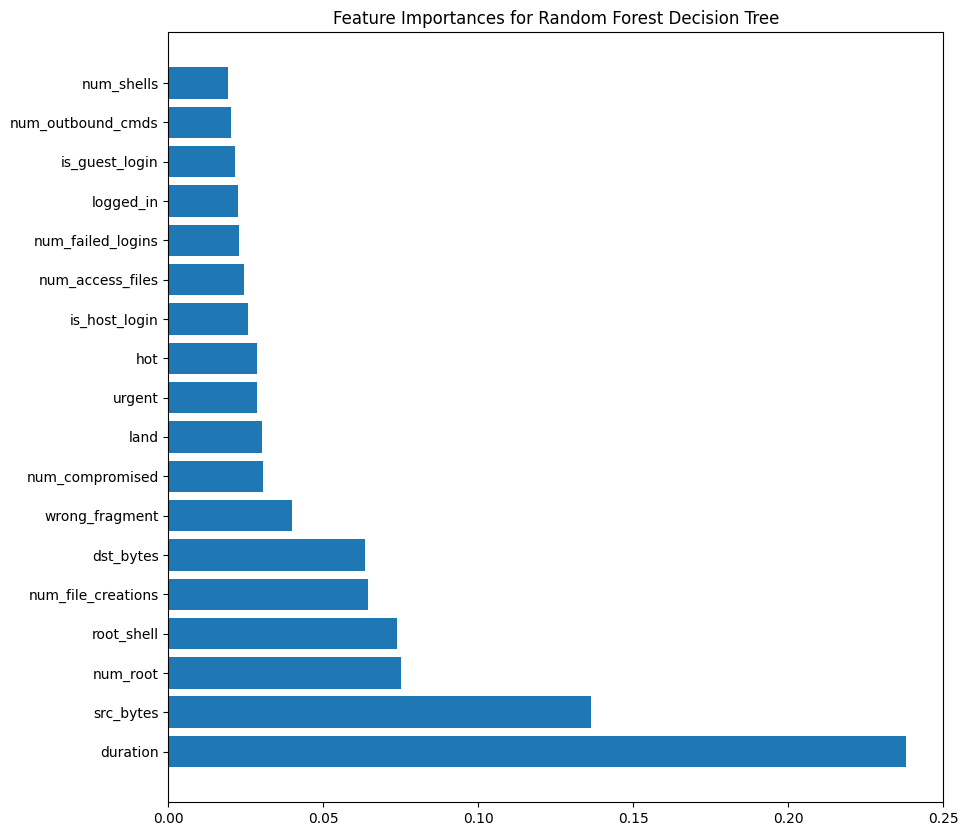

In [352]:
# Call the function f_importances to display the feature importances from the Random Forest model
# rf.feature_importances_ gives the importance of each feature in the Random Forest
# abs() is used to ensure all importances are positive, but it's typically unnecessary for Random Forest importances as they are always positive
f_importances(abs(rf.feature_importances_), features_names, top=18)